#Assignment 1: From Dirty Data to Predictive Models

## I am using the Titanic Survival Dataset (Link: https://www.kaggle.com/competitions/titanic/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
df_train = pd.read_csv('/content/train.csv')
df_test  = pd.read_csv('/content/test.csv')

#Exploratory Data Analysis

In [3]:
print(df_train.shape, df_test.shape)
df_train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#Checking which columns have missing values
missing = df_train.isnull().sum()
missing_df = pd.DataFrame({'Count': missing, 'Percentage': (missing/len(df_train)*100).round(2)})
print(missing_df[missing_df['Count'] > 0])

          Count  Percentage
Age         177       19.87
Cabin       687       77.10
Embarked      2        0.22


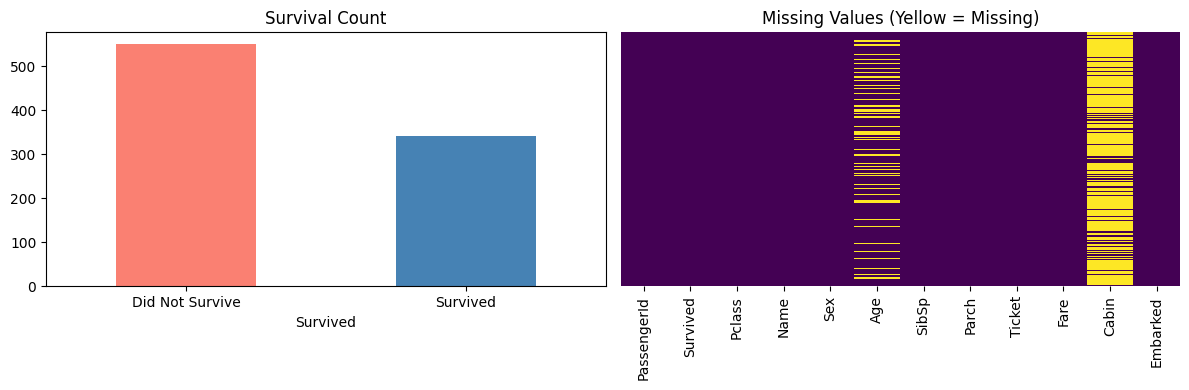

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_train['Survived'].value_counts().plot(kind='bar', ax=axes[0],
    color=['salmon', 'steelblue'])
axes[0].set_title('Survival Count')
axes[0].set_xticklabels(['Did Not Survive', 'Survived'], rotation=0)

sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False,
            cmap='viridis', ax=axes[1])
axes[1].set_title('Missing Values (Yellow = Missing)')

plt.tight_layout()
plt.savefig('eda.png', dpi=150, bbox_inches='tight')
plt.show()

# 1. Data Cleaning

In [7]:
def clean_data(df):
    df = df.copy()

    #I am dropping the Cabin column because it has 687 missing entires(77% missing) in the train set and 327 missing entires(78% missing) in the test set, so it is not really useful
    cols_to_drop = [c for c in ['Cabin', 'Name', 'Ticket', 'PassengerId'] if c in df.columns]
    df.drop(columns=cols_to_drop, inplace=True)

    #I am filling the missing Age values using the median of their specific Pclass and Sex group
    df['Age'] = df['Age'].fillna(
        df.groupby(['Pclass', 'Sex'])['Age'].transform('median'))
    df['Age'] = df['Age'].fillna(df['Age'].median())

    #Here I address the 2 missing values in the Embarked column in the train.csv
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    #In the test set the Fare column has 1 missing value
    if df['Fare'].isnull().any():
        df['Fare'] = df.groupby('Pclass')['Fare'].transform(
            lambda x: x.fillna(x.median()))

    return df

In [8]:
df_train_clean = clean_data(df_train)
df_test_clean = clean_data(df_test)

In [9]:
#Now we can confirm there are no more missing values
print(df_train_clean.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


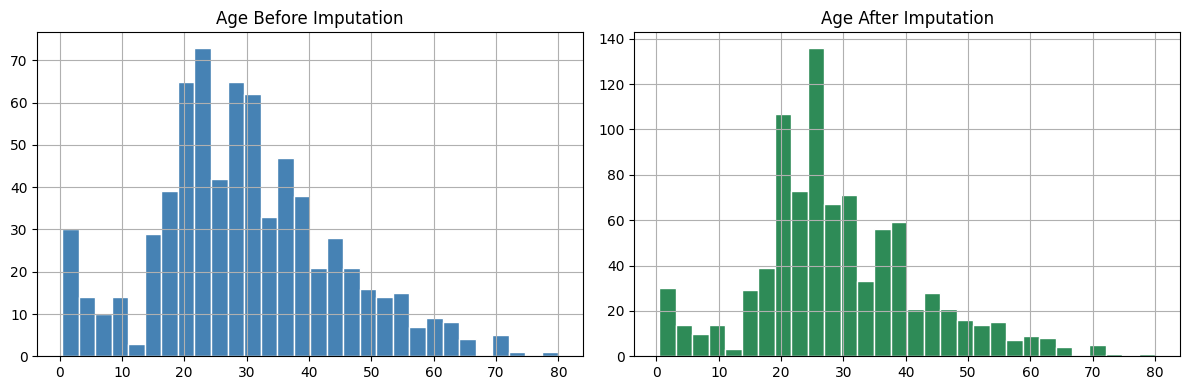

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_train['Age'].dropna().hist(bins=30, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Age Before Imputation')

df_train_clean['Age'].hist(bins=30, ax=axes[1], color='seagreen', edgecolor='white')
axes[1].set_title('Age After Imputation')

plt.tight_layout()
plt.savefig('age_imputation.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. Feature Engineering

In [11]:
def engineer_features(df):
    df = df.copy()

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                             labels=[0, 1, 2, 3, 4]).astype(int)
    df['LogFare'] = np.log1p(df['Fare'])

    df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=False)
    df.drop(columns=['SibSp', 'Parch', 'Age', 'Fare'], inplace=True)

    return df

In [12]:
df_train_fe = engineer_features(df_train_clean)
df_test_fe = engineer_features(df_test_clean)

In [13]:
df_test_fe = df_test_fe.reindex(
    columns=df_train_fe.columns.drop('Survived'), fill_value=0)

In [14]:
print(df_train_fe.columns.tolist())
df_train_fe.head(3)

['Survived', 'Pclass', 'FamilySize', 'IsAlone', 'AgeGroup', 'LogFare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


,Survived,Pclass,FamilySize,IsAlone,AgeGroup,LogFare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,2,0,2,2.110213,False,True,False,False,True
1,1,1,2,0,3,4.280593,True,False,True,False,False
2,1,3,1,1,2,2.188856,True,False,False,False,True


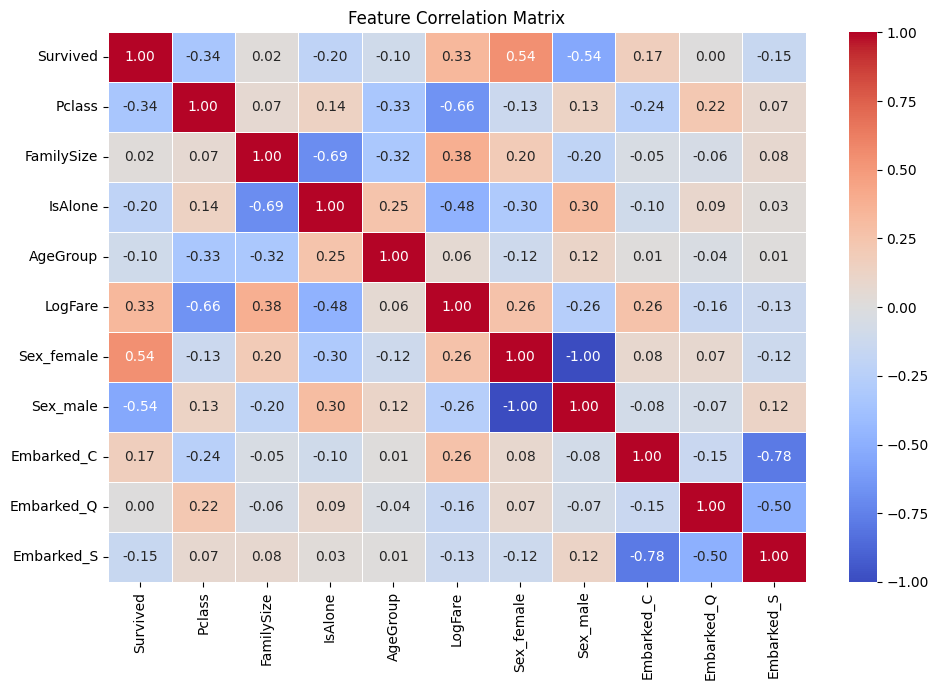

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_train_fe.corr(), annot=True, fmt='.2f',
            cmap='coolwarm', center=0, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. Model Training

In [16]:
X = df_train_fe.drop(columns=['Survived'])
y = df_train_fe['Survived']

#I am doing a 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("train size:", len(X_train), "  val size:", len(X_val))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

train size: 712   val size: 179


#Gaussian Naive Bayes

In [17]:
results = {}

#default smoothing
gnb1 = GaussianNB(var_smoothing=1e-9)
gnb1.fit(X_train, y_train)
preds1 = gnb1.predict(X_val)
acc1 = accuracy_score(y_val, preds1)
results['GaussianNB (var_smooth=1e-09)'] = {'model': gnb1, 'preds': preds1, 'acc': acc1}
print("GaussianNB var_smoothing=1e-9 accuracy:", round(acc1, 3))

#higher smoothing
gnb2 = GaussianNB(var_smoothing=1e-2)
gnb2.fit(X_train, y_train)
preds2 = gnb2.predict(X_val)
acc2 = accuracy_score(y_val, preds2)
results['GaussianNB (var_smooth=0.01)'] = {'model': gnb2, 'preds': preds2, 'acc': acc2}
print("GaussianNB var_smoothing=0.01 accuracy:", round(acc2, 3))

GaussianNB var_smoothing=1e-9 accuracy: 0.771
GaussianNB var_smoothing=0.01 accuracy: 0.782


# Linear Regression

In [18]:
#plain linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
raw_lr = np.clip(lr.predict(X_val_scaled), 0, 1)
preds_lr = (raw_lr >= 0.5).astype(int)
acc_lr = accuracy_score(y_val, preds_lr)
results['Linear Regression'] = {'model': lr, 'preds': preds_lr, 'raw': raw_lr, 'acc': acc_lr}
print("Linear Regression accuracy:", round(acc_lr, 3))

#ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
raw_ridge = np.clip(ridge.predict(X_val_scaled), 0, 1)
preds_ridge = (raw_ridge >= 0.5).astype(int)
acc_ridge = accuracy_score(y_val, preds_ridge)
results['Ridge (alpha=1.0)'] = {'model': ridge, 'preds': preds_ridge, 'raw': raw_ridge, 'acc': acc_ridge}
print("Ridge accuracy:", round(acc_ridge, 3))

#lasso
lasso = Lasso(alpha=0.01, max_iter=5000)
lasso.fit(X_train_scaled, y_train)
raw_lasso = np.clip(lasso.predict(X_val_scaled), 0, 1)
preds_lasso = (raw_lasso >= 0.5).astype(int)
acc_lasso = accuracy_score(y_val, preds_lasso)
results['LASSO (alpha=0.01)'] = {'model': lasso, 'preds': preds_lasso, 'raw': raw_lasso, 'acc': acc_lasso}
print("LASSO accuracy:", round(acc_lasso, 3))

Linear Regression accuracy: 0.816
Ridge accuracy: 0.816
LASSO accuracy: 0.799


# 4. Model Evaluation

In [19]:
summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [v['acc'] for v in results.values()]
})
summary = summary.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print(summary)

                           Model  Accuracy
0              Linear Regression  0.815642
1              Ridge (alpha=1.0)  0.815642
2             LASSO (alpha=0.01)  0.798883
3   GaussianNB (var_smooth=0.01)  0.782123
4  GaussianNB (var_smooth=1e-09)  0.770950


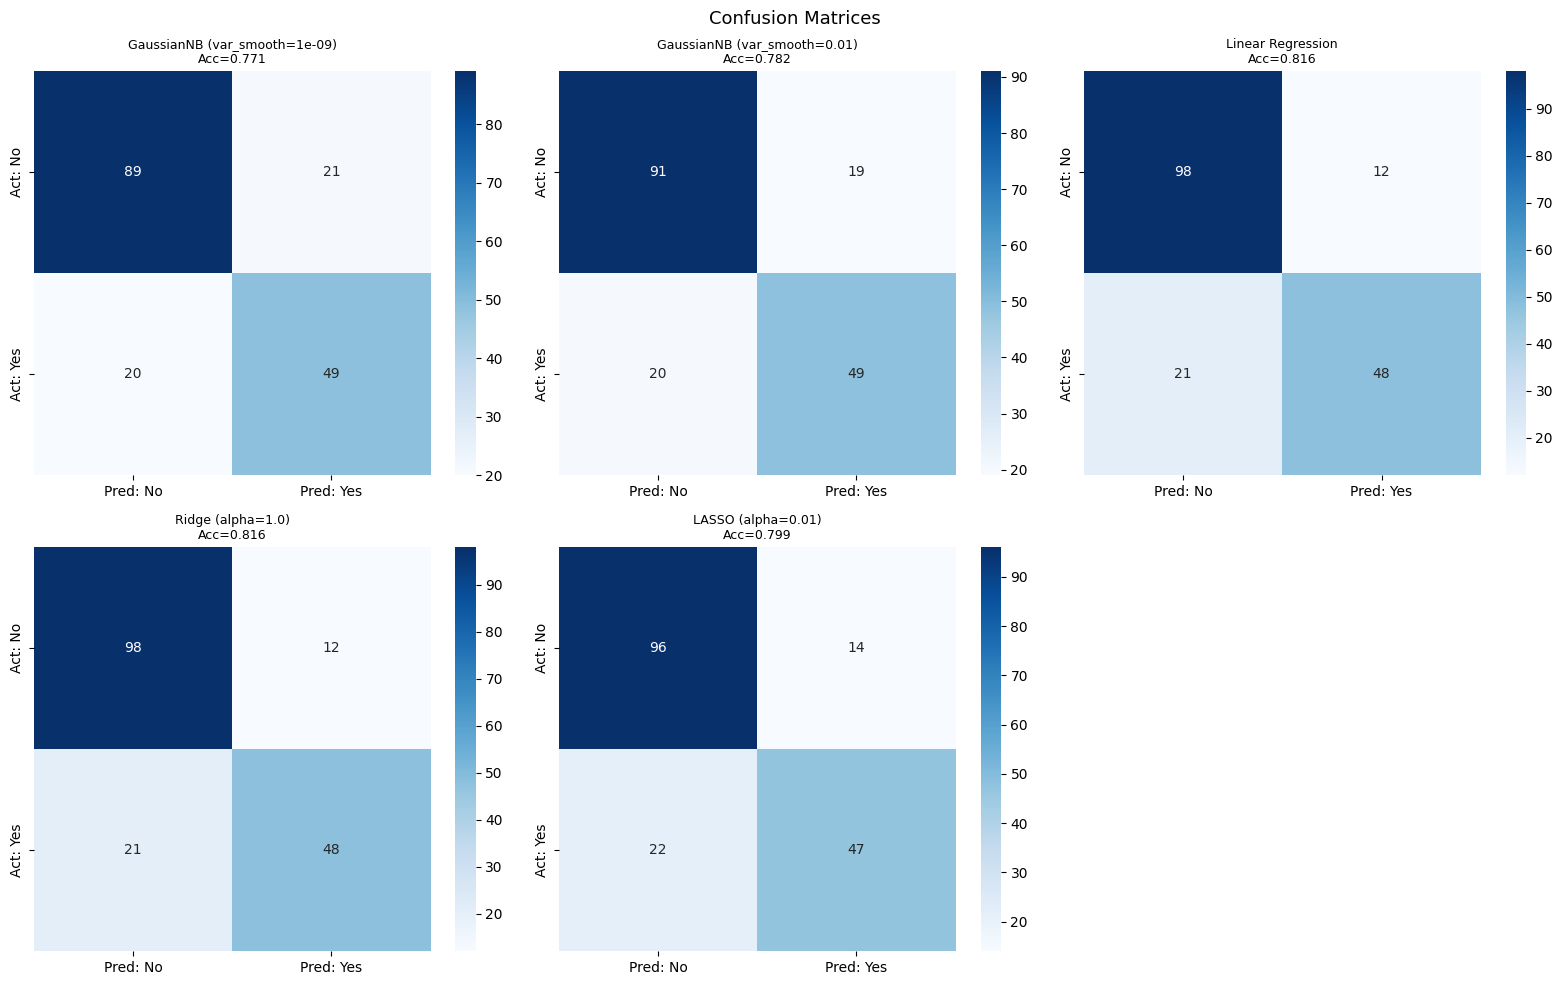

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_val, res['preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred: No', 'Pred: Yes'],
                yticklabels=['Act: No', 'Act: Yes'])
    axes[i].set_title(name + '\nAcc=' + str(round(res['acc'], 3)), fontsize=9)

for j in range(len(results), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Confusion Matrices', fontsize=13)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
print("GaussianNB (default smoothing)")
print(classification_report(y_val, results['GaussianNB (var_smooth=1e-09)']['preds'],
                             target_names=['Did Not Survive', 'Survived']))

print("Ridge Regression")
print(classification_report(y_val, results['Ridge (alpha=1.0)']['preds'],
                             target_names=['Did Not Survive', 'Survived']))

GaussianNB (default smoothing)
                 precision    recall  f1-score   support

Did Not Survive       0.82      0.81      0.81       110
       Survived       0.70      0.71      0.71        69

       accuracy                           0.77       179
      macro avg       0.76      0.76      0.76       179
   weighted avg       0.77      0.77      0.77       179

Ridge Regression
                 precision    recall  f1-score   support

Did Not Survive       0.82      0.89      0.86       110
       Survived       0.80      0.70      0.74        69

       accuracy                           0.82       179
      macro avg       0.81      0.79      0.80       179
   weighted avg       0.81      0.82      0.81       179



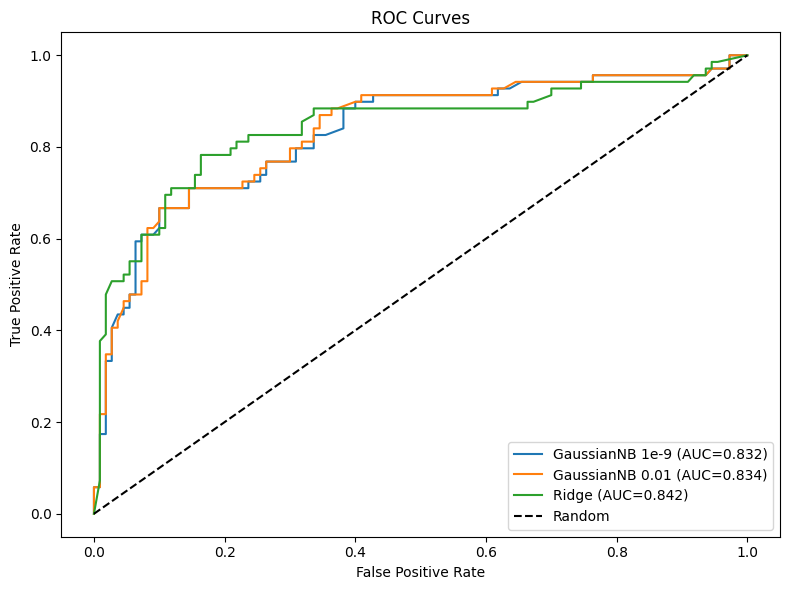

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

probs1 = results['GaussianNB (var_smooth=1e-09)']['model'].predict_proba(X_val)[:, 1]
fpr1, tpr1, _ = roc_curve(y_val, probs1)
ax.plot(fpr1, tpr1, label='GaussianNB 1e-9 (AUC=' + str(round(auc(fpr1, tpr1), 3)) + ')')

probs2 = results['GaussianNB (var_smooth=0.01)']['model'].predict_proba(X_val)[:, 1]
fpr2, tpr2, _ = roc_curve(y_val, probs2)
ax.plot(fpr2, tpr2, label='GaussianNB 0.01 (AUC=' + str(round(auc(fpr2, tpr2), 3)) + ')')

fpr3, tpr3, _ = roc_curve(y_val, results['Ridge (alpha=1.0)']['raw'])
ax.plot(fpr3, tpr3, label='Ridge (AUC=' + str(round(auc(fpr3, tpr3), 3)) + ')')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

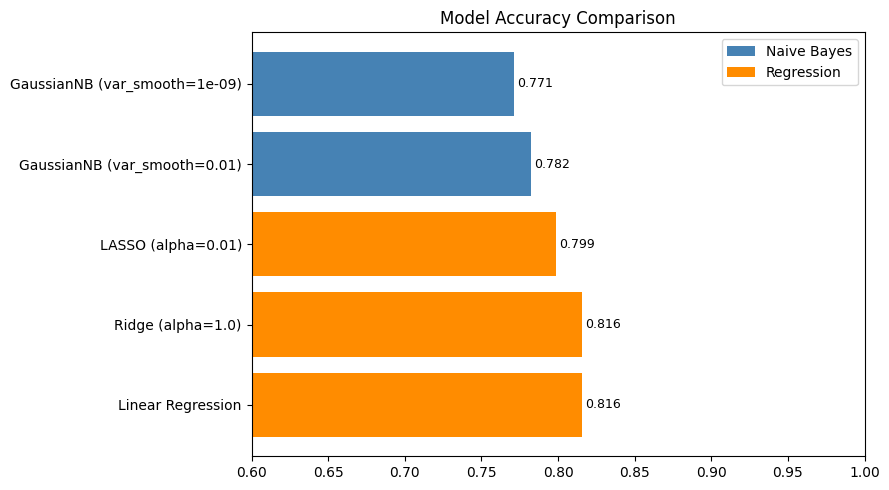

In [23]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['steelblue' if 'NB' in m else 'darkorange' for m in summary['Model']]
bars = ax.barh(summary['Model'], summary['Accuracy'], color=colors)
ax.set_xlim(0.6, 1.0)
ax.set_title('Model Accuracy Comparison')
for bar, acc in zip(bars, summary['Accuracy']):
    ax.text(acc + 0.002, bar.get_y() + bar.get_height()/2,
            str(round(acc, 3)), va='center', fontsize=9)

ax.legend(handles=[Patch(facecolor='steelblue', label='Naive Bayes'),
                   Patch(facecolor='darkorange', label='Regression')])
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

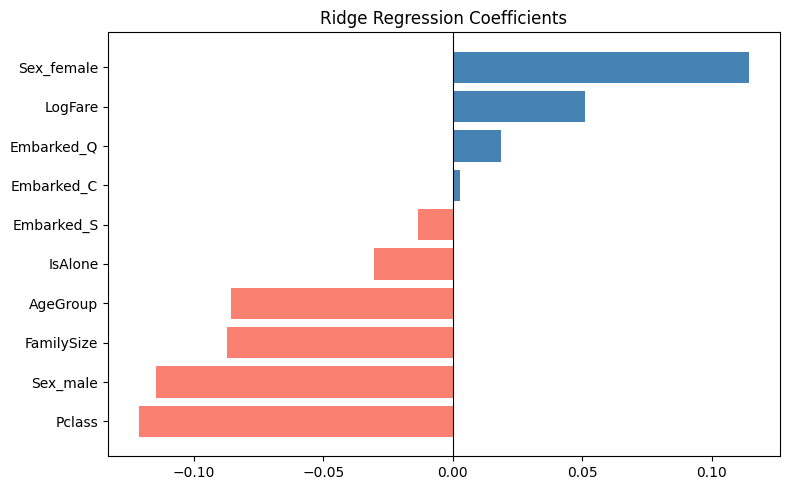

In [24]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': results['Ridge (alpha=1.0)']['model'].coef_
})
coef_df = coef_df.sort_values('Coefficient')

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(coef_df['Feature'], coef_df['Coefficient'],
        color=['salmon' if c < 0 else 'steelblue' for c in coef_df['Coefficient']])
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Ridge Regression Coefficients')
plt.tight_layout()
plt.savefig('ridge_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
#Just for zipping all my files
#!zip -r submission.zip . -x "sample_data/*"

  adding: .config/ (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2026.01.16/ (stored 0%)
  adding: .config/logs/2026.01.16/14.24.29.392089.log (deflated 56%)
  adding: .config/logs/2026.01.16/14.23.31.981136.log (deflated 92%)
  adding: .config/logs/2026.01.16/14.24.03.314209.log (deflated 58%)
  adding: .config/logs/2026.01.16/14.24.18.954466.log (deflated 58%)
  adding: .config/logs/2026.01.16/14.24.13.071214.log (deflated 87%)
  adding: .config/logs/2026.01.16/14.24.28.646070.log (deflated 57%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/configurations/